Importing Libraries

In [1]:
import os
import tensorflow as tf
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import random
import cv2
import pathlib
from pathlib import Path
import pandas
import shutil
import copy
import torch
from PIL import Image
from torch.utils.data import Dataset 
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import random_split
from torch.optim.lr_scheduler import ReduceLROnPlateau 
import torch.nn as nn
from torchvision import utils
from torchvision.datasets import ImageFolder
import splitfolders
from torchsummary import summary
import torch.nn.functional as F
import itertools 
from tqdm.notebook import trange, tqdm 
from torch import optim
import pickle
import warnings
warnings.filterwarnings('ignore')

Data Importing and preprocessing 

In [2]:
# Defining the path to image directory
images_path = Path(r'C:\Users\c2286622\Desktop\Project\Data')

In [3]:
# Getting the list of classes (subdirectories) in the images_path
classes = [class_name for class_name in os.listdir(images_path) 
           if os.path.isdir(os.path.join(images_path, class_name))]


In [4]:
# Printing the number of images in each class
for class_name in classes:
    class_path = os.path.join(images_path, class_name)
    num_images = len(os.listdir(class_path))
    print(f'{class_name}: {num_images} images')

glioma_tumor: 6308 images
meningioma_tumor: 6391 images
Normal: 3066 images
pituitary_tumor: 5908 images


In [5]:
# Ballancing dataset to 3000 images per image class
def select_images(images_path, target_count):
    selected_paths = {}
    for category in os.listdir(images_path):
        category_path = os.path.join(images_path, category)
        if os.path.isdir(category_path):
            images = os.listdir(category_path)
            random.shuffle(images)
            selected_images = images[:target_count]
            selected_paths[category] = [os.path.join(category_path, img) for img in selected_images]
            print(f"Selected {len(selected_images)} images from category '{category}'")
    return selected_paths

selected_image_paths = select_images(images_path, 3000)

Selected 3000 images from category 'glioma_tumor'
Selected 3000 images from category 'meningioma_tumor'
Selected 3000 images from category 'Normal'
Selected 3000 images from category 'pituitary_tumor'


In [6]:
# Printing the total number of images selected across all classes
total_images = sum(len(paths) for paths in selected_image_paths.values())
print(f"Total number of images selected: {total_images}")

Total number of images selected: 12000


In [7]:
# Defining function to load dataset for TensorFlow
def load_dataset(file_paths, image_size=(224, 224), batch_size=32):
    resize_images = lambda img: tf.image.resize(img, image_size)
    decode_images = lambda file: tf.image.decode_jpeg(tf.io.read_file(file), channels=3)

    # applying  lambdas to dataset
    dataset = tf.data.Dataset.from_tensor_slices(file_paths)
    dataset = dataset.map(decode_images)
    dataset = dataset.map(resize_images)

    return dataset

file_paths = ["path/to/image1.jpg", "path/to/image2.jpg"]
image_size = (224, 224)
dataset = load_dataset(file_paths, image_size)


In [8]:
def load_dataset(image_paths, image_size=(224, 224), batch_size=32):
    # Flattening the dictionary of image paths into a single list
    all_image_paths = [path for paths in image_paths.values() for path in paths]

    # Defining separate functions for decoding and resizing to clear up ambiguity for AutoGraph
    def decode_image(file_path):
        return tf.image.decode_jpeg(tf.io.read_file(file_path), channels=3)
    
    def resize_image(image):
        return tf.image.resize(image, image_size)
    
    # Use TensorFlow to load dataset
    return tf.data.Dataset.from_tensor_slices(all_image_paths) \
                          .map(decode_image) \
                          .map(resize_image) \
                          .batch(batch_size)

dataset = load_dataset(selected_image_paths)


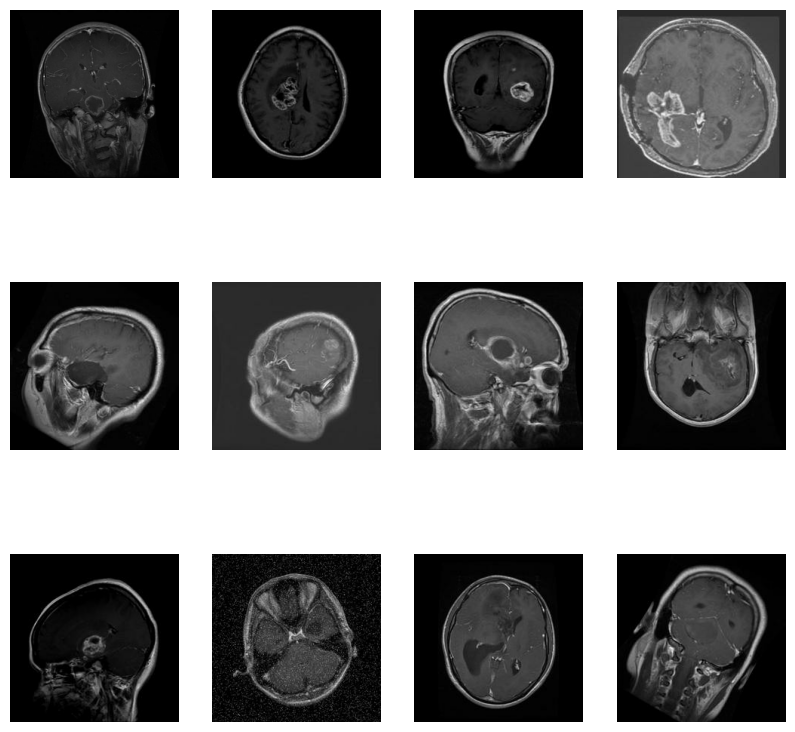

In [9]:
# Visualization of images
plt.figure(figsize=(10, 10))
for images in dataset.take(1):
    for i in range(12):
        ax = plt.subplot(3, 4, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.axis("off")

In [10]:
# Defining functions for preprocessing dataset and applying Gaussian Bluriring using OpenCV
def preprocess_image(image_path):
    # Read the file
    image_content = tf.io.read_file(image_path)
    try:
        image = tf.image.decode_image(image_content, channels=3, expand_animations=False)
    except tf.errors.InvalidArgumentError:
        print(f"Skipping file with unsupported format: {image_path}")
        return None, None  # Return None to indicate error in processing this image

    original_image = tf.image.resize(image, (224, 224))

    def blur_opencv(image):
        image = image.numpy()
        blurred_image = cv2.GaussianBlur(image, (5, 5), 0)
        return blurred_image

    blurred_image = tf.py_function(blur_opencv, [original_image], tf.uint8)
    blurred_image = tf.cast(blurred_image, tf.float32) / 255.0
    original_image = tf.cast(original_image, tf.float32) / 255.0

    return original_image, blurred_image

In [11]:
#Load dataset for TwnsorFlow
def load_dataset(image_paths, batch_size=32):
    dataset = tf.data.Dataset.from_tensor_slices(image_paths)
    dataset = dataset.map(preprocess_image)
    
    # Remove any elements that returned None due to errors
    dataset = dataset.filter(lambda x, y: x is not None)
    dataset = dataset.batch(batch_size)
    return dataset

In [12]:
# Filter the image paths to include only supported formats
supported_formats = ['.jpg', '.jpeg', '.png', '.gif', '.bmp']
all_image_paths = [
    path for paths in selected_image_paths.values() for path in paths
    if any(path.lower().endswith(ext) for ext in supported_formats)
]
dataset = load_dataset(all_image_paths)

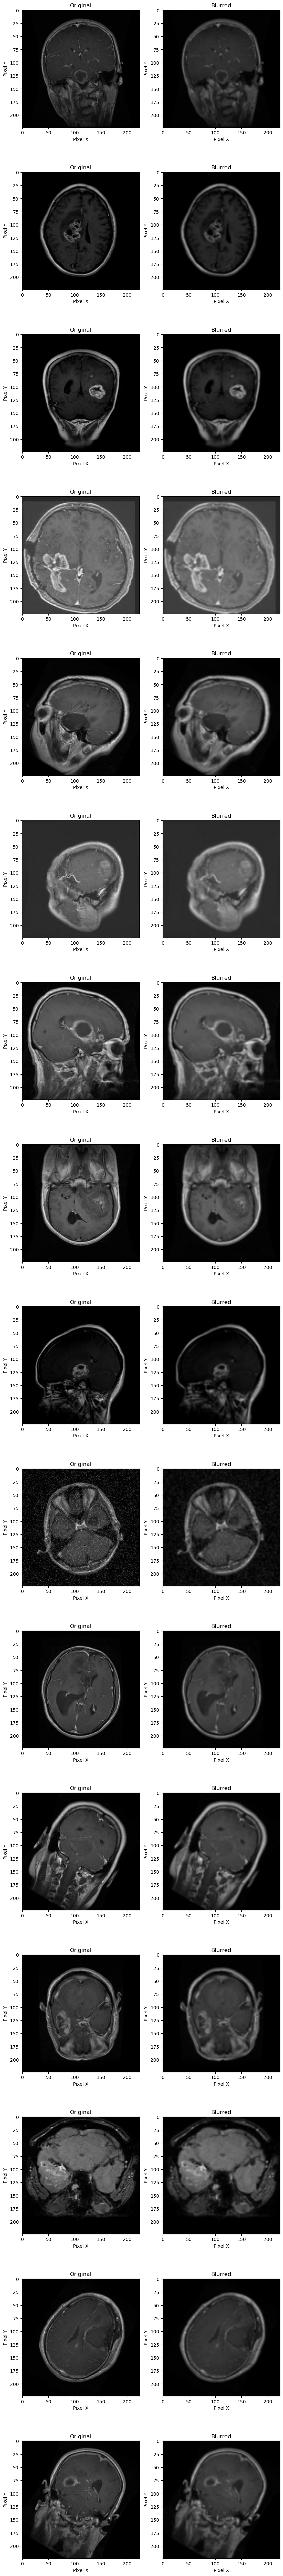

In [13]:
# Compare and visualise samples of origal image verses Blurred images in dataset
def visualize_dataset(dataset):
    plt.figure(figsize=(10, 10*10))
    i = 0
    for original_images, blurred_images in dataset.take(1):  
        for original, blurred in zip(original_images.numpy(), blurred_images.numpy()):
            if i >= 16:
                break
                
            ax = plt.subplot(16, 2, 2*i + 1)
            ax.imshow(original)
            ax.set_title('Original')
            ax.axis("on")
            ax.set_xlabel('Pixel X')
            ax.set_ylabel('Pixel Y')
            
            ax = plt.subplot(16, 2, 2*i + 2)
            ax.imshow(blurred)
            ax.set_title('Blurred')
            ax.axis("on")
            ax.set_xlabel('Pixel X')
            ax.set_ylabel('Pixel Y')            
            i += 1
    plt.show()

visualize_dataset(dataset)


In [14]:
# Dataset Splitting
def split_data(image_paths, train_ratio=0.8):
    train_paths = {}
    val_paths = {}
    for category, paths in image_paths.items():
        random.shuffle(paths)
        split_idx = int(len(paths) * train_ratio)
        train_paths[category] = paths[:split_idx]
        val_paths[category] = paths[split_idx:]
    return train_paths, val_paths

train_image_paths, val_image_paths = split_data(selected_image_paths)


In [15]:
# save Copy of image to a new directory
    def save_images(image_paths, base_dir):
    for category, paths in image_paths.items():
        category_dir = os.path.join(base_dir, category)
        os.makedirs(category_dir, exist_ok=True)
        for i, path in enumerate(paths):
            shutil.copy(path, os.path.join(category_dir, f"{i}.jpg"))

# Defining the base directories for train and validation datasets
base_train_dir = 'C:/Users/C2286622/Desktop/Project/Train_Val/Train'
base_val_dir = 'C:/Users/C2286622/Desktop/Project/Train_Val/Val'

# Save training and validation images
save_images(train_image_paths, base_train_dir)
save_images(val_image_paths, base_val_dir)


Model set up and Training

In [16]:
# Load Train and validation datset
data_dir = r'C:\Users\c2286622\Desktop\Project\Train_Val'
data_dir = pathlib.Path(data_dir)

In [17]:
# Defining the transformation without normalization
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
])

# Create an ImageFolder dataset
dataset = ImageFolder(root=data_dir, transform=transform)

# Initialise variables for mean and std
mean = np.zeros(3)
std = np.zeros(3)
total_samples = len(dataset)

# Iterate over the dataset to calculate mean and std
for data, _ in dataset:
    mean += data.numpy().mean(axis=(1, 2))
    std += data.numpy().std(axis=(1, 2))

# Calculate the overall mean and std
mean /= total_samples
std /= total_samples

print("Calculated mean:", mean)
print("Calculated std:", std)

Calculated mean: [0.20380913 0.20380913 0.20380913]
Calculated std: [0.17531471 0.17531471 0.17531471]


In [18]:
# defining transformation
transform = transforms.Compose(
    [
        transforms.Resize((224,224)),
        transforms.RandomHorizontalFlip(p=0.5),
        transforms.RandomVerticalFlip(p=0.5),
        transforms.RandomRotation(30),
        transforms.ToTensor(),
        transforms.Normalize(mean = [0.20380913, 0.20380913, 0.20380913],
                             std = [0.17531471, 0.17531471, 0.17531471])
   ]
)

In [19]:
# Defining an object of the custom dataset for the train and validation.
train_set = torchvision.datasets.ImageFolder(data_dir.joinpath("train"), transform=transform) 
train_set.transform
val_set = torchvision.datasets.ImageFolder(data_dir.joinpath("val"), transform=transform)
val_set.transform

Compose(
    Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=True)
    RandomHorizontalFlip(p=0.5)
    RandomVerticalFlip(p=0.5)
    RandomRotation(degrees=[-30.0, 30.0], interpolation=nearest, expand=False, fill=0)
    ToTensor()
    Normalize(mean=[0.20380913, 0.20380913, 0.20380913], std=[0.17531471, 0.17531471, 0.17531471])
)

In [20]:
# Labeling associated classes of brain tumour with normal brain tissues
CLA_label = {
    0: 'glioma_tumor',
    1: 'meningioma_tumor',
    2: 'Normal',
    3: 'pituitary_tumor'
}

In [21]:
# craeting data loader for training and validation with PyTorch
batch_size = 64

train_loader = torch.utils.data.DataLoader(train_set, batch_size = batch_size, shuffle = True, num_workers = 16)
val_loader = torch.utils.data.DataLoader(val_set, batch_size = batch_size, shuffle = True, num_workers = 16)

In [22]:
# printing the shape for Training and Validation data
for key, value in {'Training data': train_loader, "Validation data": val_loader}.items():
    for X, y in value:
        print(f"{key}:")
        print(f"Shape of X : {X.shape}")
        print(f"Shape of y: {y.shape} {y.dtype}\n")
        break

Training data:
Shape of X : torch.Size([64, 3, 224, 224])
Shape of y: torch.Size([64]) torch.int64

Validation data:
Shape of X : torch.Size([64, 3, 224, 224])
Shape of y: torch.Size([64]) torch.int64



In [23]:
# Calculating the output height and width of the convolutional layer
def findConv2dOutShape(hin,win,conv,pool=2):
    # get conv arguments
    kernel_size = conv.kernel_size
    stride=conv.stride
    padding=conv.padding
    dilation=conv.dilation

    hout=np.floor((hin+2*padding[0]-dilation[0]*(kernel_size[0]-1)-1)/stride[0]+1)
    wout=np.floor((win+2*padding[1]-dilation[1]*(kernel_size[1]-1)-1)/stride[1]+1)

    if pool:
        hout/=pool
        wout/=pool
    return int(hout),int(wout)

In [24]:
# Defining Architecture For CNN_TUMOR Model
class CNN_TUMOR(nn.Module):
    
    # Network Initialisation
    def __init__(self, params):
        
        super(CNN_TUMOR, self).__init__()
    
        Cin,Hin,Win = params["shape_in"]
        init_f = params["initial_filters"] 
        num_fc1 = params["num_fc1"]  
        num_classes = params["num_classes"] 
        self.dropout_rate = params["dropout_rate"] 
        
        # Convolution Layers
        self.conv1 = nn.Conv2d(Cin, init_f, kernel_size=3)
        h,w=findConv2dOutShape(Hin,Win,self.conv1)
        self.conv2 = nn.Conv2d(init_f, 2*init_f, kernel_size=3)
        h,w=findConv2dOutShape(h,w,self.conv2)
        self.conv3 = nn.Conv2d(2*init_f, 4*init_f, kernel_size=3)
        h,w=findConv2dOutShape(h,w,self.conv3)
        self.conv4 = nn.Conv2d(4*init_f, 8*init_f, kernel_size=3)
        h,w=findConv2dOutShape(h,w,self.conv4)
        
        # computing the flattening size
        self.num_flatten=h*w*8*init_f
        self.fc1 = nn.Linear(self.num_flatten, num_fc1)
        self.fc2 = nn.Linear(num_fc1, num_classes)

    def forward(self,X):
        
        # Convolution & Pool Layers
        X = F.relu(self.conv1(X)); 
        X = F.max_pool2d(X, 2, 2)
        X = F.relu(self.conv2(X))
        X = F.max_pool2d(X, 2, 2)
        X = F.relu(self.conv3(X))
        X = F.max_pool2d(X, 2, 2)
        X = F.relu(self.conv4(X))
        X = F.max_pool2d(X, 2, 2)
        X = X.view(-1, self.num_flatten)
        X = F.relu(self.fc1(X))
        X = F.dropout(X, self.dropout_rate)
        X = self.fc2(X)
        return F.softmax(X, dim=1)


In [25]:
# Creating an instance of a CNN model
params_model={
    "shape_in": (3,224,224), 
    "initial_filters": 8,    
    "num_fc1": 100,
    "dropout_rate": 0.25,
    "num_classes": 4
}

# Creating instantiation of Network class
cnn_model = CNN_TUMOR(params_model)

# defining computation hardware approach (GPU/CPU)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = cnn_model.to(device)

In [26]:
# Model Summary for CNN Model
summary(cnn_model, input_size=(3, 224, 224),device=device.type)

Layer (type:depth-idx)                   Param #
├─Conv2d: 1-1                            224
├─Conv2d: 1-2                            1,168
├─Conv2d: 1-3                            4,640
├─Conv2d: 1-4                            18,496
├─Linear: 1-5                            921,700
├─Linear: 1-6                            404
Total params: 946,632
Trainable params: 946,632
Non-trainable params: 0


Layer (type:depth-idx)                   Param #
├─Conv2d: 1-1                            224
├─Conv2d: 1-2                            1,168
├─Conv2d: 1-3                            4,640
├─Conv2d: 1-4                            18,496
├─Linear: 1-5                            921,700
├─Linear: 1-6                            404
Total params: 946,632
Trainable params: 946,632
Non-trainable params: 0

In [27]:
# Setup model optimser 

# Defining the Adam optimiser and its learning rate
opt = optim.Adam(cnn_model.parameters(), lr=3e-4)

# Defining a Learning rate scheduler
lr_scheduler = ReduceLROnPlateau(opt, mode='min',factor=0.5, patience=20,verbose=1)

In [28]:
# Setting up the training and validation Parameters

def Train_Val(model, params,verbose=False):
    
    # Get the parameters
    epochs=params["epochs"]
    loss_func=params["f_loss"]
    opt=params["optimiser"]
    train_dl=params["train"]
    val_dl=params["val"]
    lr_scheduler=params["lr_change"]
    weight_path=params["weight_path"]
    
    # history of loss values in each epoch
    loss_history={"train": [],"val": []} 
    # histroy of metric values in each epoch
    metric_history={"train": [],"val": []} 
    # a deep copy of weights for the best performing model
    best_model_wts = copy.deepcopy(model.state_dict()) 
    # initialize best loss to a large value
    best_loss=float('inf') 

# Train Model n_epochs (the progress of training by printing the epoch number and the associated learning rate. It can be helpful for debugging, monitoring the learning rate schedule, or gaining insights into the training process.) 
    for epoch in tqdm(range(epochs)):
        
        # Get the Learning Rate
        current_lr=get_lr(opt)
        if(verbose):
            print('Epoch {}/{}, current lr={}'.format(epoch, epochs - 1, current_lr))
        
# Train Model Process
        model.train()
        train_loss, train_metric = loss_epoch(model,loss_func,train_dl,opt)

        # collect losses
        loss_history["train"].append(train_loss)
        metric_history["train"].append(train_metric)
        

# Evaluating the Model Process       
        model.eval()
        with torch.no_grad():
            val_loss, val_metric = loss_epoch(model,loss_func,val_dl)
        
        # store best model
        if(val_loss < best_loss):
            best_loss = val_loss
            best_model_wts = copy.deepcopy(model.state_dict())
            
            # store weights into a local file
            torch.save(model.state_dict(), weight_path)
            if(verbose):
                print("Copied best model weights!")
        
        # collect loss and metric for validation dataset
        loss_history["val"].append(val_loss)
        metric_history["val"].append(val_metric)
        
        # learning rate schedule
        lr_scheduler.step(val_loss)
        if current_lr != get_lr(opt):
            if(verbose):
                print("Loading best model weights!")
            model.load_state_dict(best_model_wts) 

        if(verbose):
            print(f"train loss: {train_loss:.6f}, dev loss: {val_loss:.6f}, accuracy: {100*val_metric:.2f}")
            print("-"*10) 

    # load best model weights
    model.load_state_dict(best_model_wts)
        
    return model, loss_history, metric_history

In [29]:
# extracting the learning rate from a PyTorch optimizer
def get_lr(optimizer):
    for param_group in optimizer.param_groups:
        return param_group['lr']

In [30]:
# Defining the Loss Epoch for computing the average loss and metric during training or evaluation
def loss_epoch(model, loss_func, dataloader, optimizer=None):
    total_loss = 0.0
    total_metric = 0.0
    total_samples = 0

    for inputs, targets in dataloader:
        if optimizer:
            optimizer.zero_grad()

        outputs = model(inputs)
        loss = loss_func(outputs, targets)
        
        if optimizer:
            loss.backward()
            optimizer.step()

        total_loss += loss.item() * inputs.size(0)
        total_metric += compute_metric(outputs, targets)
        total_samples += inputs.size(0)

    return total_loss / total_samples, total_metric / total_samples

def loss_epoch(model, loss_func, dataloader, optimizer=None):
    total_loss = 0.0
    total_metric = 0.0
    total_samples = 0

    for inputs, targets in dataloader:
        if optimizer:
            optimizer.zero_grad()

        outputs = model(inputs)
        loss = loss_func(outputs, targets)
        
        if optimizer:
            loss.backward()
            optimizer.step()

        total_loss += loss.item() * inputs.size(0)
        total_metric += compute_metric(outputs, targets)
        total_samples += inputs.size(0)

    return total_loss / total_samples, total_metric / total_samples


In [31]:
# Defining the function for calculating prediction metrics
def compute_metric(predictions, targets):
    _, predicted = torch.max(predictions, 1)
    correct = (predicted == targets).sum().item()
    accuracy = correct / targets.size(0)
    return accuracy

In [37]:
# Defining various parameters used for training and evaluation of a cnn_model

params_train={
 "train": train_loader,"val": val_loader,
 "epochs": 60,
 "optimiser": optim.Adam(cnn_model.parameters(),lr=3e-4),
 "lr_change": ReduceLROnPlateau(opt,
                                mode='min',
                                factor=0.5,
                                patience=20,
                                verbose=0),
 "f_loss": nn.NLLLoss(reduction="sum"),
 "weight_path": "weights.pt",
}

# training and validating the model
cnn_model,loss_hist,metric_hist = Train_Val(cnn_model,params_train)

  0%|          | 0/60 [00:00<?, ?it/s]

Model Evaluation

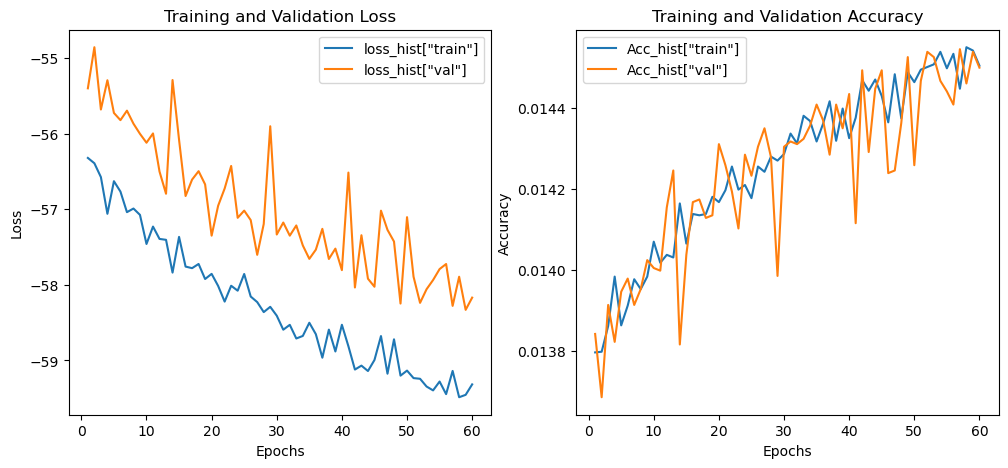

In [38]:
# Computing and Printing the training and validation lose and accuracy
epochs = params_train["epochs"]
fig, ax = plt.subplots(1, 2, figsize=(12, 5))

sns.lineplot(x=[*range(1, epochs + 1)], y=loss_hist["train"], ax=ax[0], label='loss_hist["train"]')
sns.lineplot(x=[*range(1, epochs + 1)], y=loss_hist["val"], ax=ax[0], label='loss_hist["val"]')
sns.lineplot(x=[*range(1, epochs + 1)], y=metric_hist["train"], ax=ax[1], label='Acc_hist["train"]')
sns.lineplot(x=[*range(1, epochs + 1)], y=metric_hist["val"], ax=ax[1], label='Acc_hist["val"]')

# Set plot titles and labels
ax[0].set_title('Training and Validation Loss')
ax[1].set_title('Training and Validation Accuracy')
ax[0].set_xlabel('Epochs')
ax[1].set_xlabel('Epochs')
ax[0].set_ylabel('Loss')
ax[1].set_ylabel('Accuracy')

ax[0].legend()
ax[1].legend()

plt.show()


In [39]:
# Defining function For Classification Report
def Ture_and_Pred(val_loader, model):
    i = 0
    y_true = []
    y_pred = []
    for images, labels in val_loader:
        images = images.to(device)
        labels = labels.numpy()
        outputs = model(images)
        _, pred = torch.max(outputs.data, 1)
        pred = pred.detach().cpu().numpy()
        
        y_true = np.append(y_true, labels)
        y_pred = np.append(y_pred, pred)
    
    return y_true, y_pred


# check confusion matrix for error analysis
y_true, y_pred = Ture_and_Pred(val_loader, cnn_model)

print(classification_report(y_true, y_pred), '\n\n')
cm = confusion_matrix(y_true, y_pred)

              precision    recall  f1-score   support

         0.0       0.93      0.96      0.94       600
         1.0       0.91      0.88      0.89       600
         2.0       0.91      0.84      0.88       600
         3.0       0.91      0.98      0.94       600

    accuracy                           0.92      2400
   macro avg       0.92      0.92      0.91      2400
weighted avg       0.92      0.92      0.91      2400
 




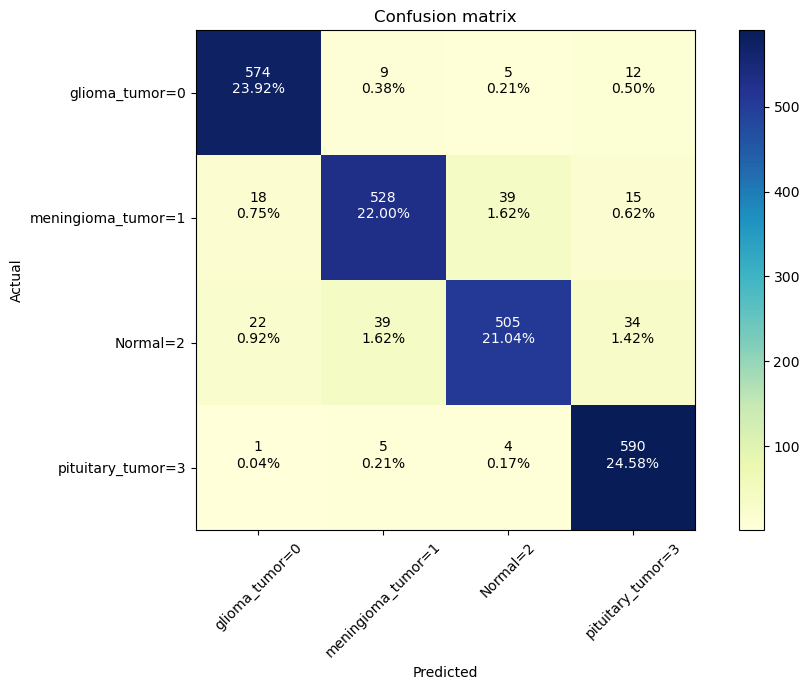

In [40]:
# Ploting Confusion Matrix
def show_confusion_matrix(cm, CLA_label, title='Confusion matrix', cmap=plt.cm.YlGnBu):
    
    plt.figure(figsize=(10,7))
    plt.grid(False)
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(CLA_label))

    plt.xticks(tick_marks, [f"{value}={key}" for key , value in CLA_label.items()], rotation=45)
    plt.yticks(tick_marks, [f"{value}={key}" for key , value in CLA_label.items()])

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, f"{cm[i,j]}\n{cm[i,j]/np.sum(cm)*100:.2f}%", horizontalalignment="center", color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('Actual')
    plt.xlabel('Predicted')
    plt.tight_layout()
    plt.show()

show_confusion_matrix(cm, CLA_label)

In [41]:
# Printing the model
print(model)

CNN_TUMOR(
  (conv1): Conv2d(3, 8, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(8, 16, kernel_size=(3, 3), stride=(1, 1))
  (conv3): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1))
  (conv4): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
  (fc1): Linear(in_features=9216, out_features=100, bias=True)
  (fc2): Linear(in_features=100, out_features=4, bias=True)
)


Saving model

In [42]:
# save model as .pkl

# Defining the filename for saving the model
filename = 'brain_tumor_classification_model_for_Blur_MRI_Final.pkl'

# Saving the model to disk using pickle
with open(filename, 'wb') as file:
    pickle.dump(cnn_model, file)

print(f"Model saved as {filename} successfully!")

Model saved as brain_tumor_classification_model_for_Blur_MRI_Final.pkl successfully!
